In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import riiideducation
env = riiideducation.make_env()
iter_test = env.iter_test()

In [1]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import gc

# dir_path = '/kaggle/input/riiid-test-answer-prediction/'
dir_path = '/home/zuoyuhui/datasets/riid准确回答/'
file_train = 'train.csv'
file_questions = 'questions.csv'
file_lectures = 'lectures.csv'

In [2]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})
import seaborn as sns

# modelling
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RepeatedKFold, cross_val_score, cross_val_predict, KFold
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.svm import LinearSVR, SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler, StandardScaler
from collections import Counter

In [3]:
nrows = 100 * 10000
train = pd.read_csv(
                    dir_path + file_train, 
                    nrows=nrows, 
                    usecols=['row_id', 'timestamp', 'user_id', 'content_id', 
                             'content_type_id', 'task_container_id', 'answered_correctly',
                            'prior_question_elapsed_time','prior_question_had_explanation'],
                    dtype={
                            'row_id': 'int64',
                            'timestamp': 'int64',
                            'user_id': 'int32',
                            'content_id': 'int16',
                            'content_type_id': 'int8',
                            'task_container_id': 'int8',
                            'answered_correctly': 'int8',
                            'prior_question_elapsed_time': 'float32',
                            'prior_question_had_explanation': 'str'
                        }
                   )

lectures = pd.read_csv(
                       dir_path + file_lectures, 
                       usecols=['lecture_id','tag','part','type_of'], 
                       nrows=nrows,
                       dtype={
                           'lecture_id': 'int16',
                           'tag': 'int16',
                           'part': 'int8',
                           'type_of': 'str'
                       }
                    )

questions = pd.read_csv(
                        dir_path + file_questions, 
                        nrows=nrows,
                        usecols=['question_id','bundle_id','part','tags'], 
                        dtype={
                           'question_id': 'int16',
                           'bundle_id': 'int16',
                           'part': 'int8',
                           'tags': 'str'
                       }
                    )


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 9 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   row_id                          1000000 non-null  int64  
 1   timestamp                       1000000 non-null  int64  
 2   user_id                         1000000 non-null  int32  
 3   content_id                      1000000 non-null  int16  
 4   content_type_id                 1000000 non-null  int8   
 5   task_container_id               1000000 non-null  int8   
 6   answered_correctly              1000000 non-null  int8   
 7   prior_question_elapsed_time     976277 non-null   float32
 8   prior_question_had_explanation  996184 non-null   object 
dtypes: float32(1), int16(1), int32(1), int64(2), int8(3), object(1)
memory usage: 35.3+ MB


In [5]:
train = train[train.content_type_id==0]  # 如果事件是向用户提出的问题，则为0；如果事件是用户正在观看讲座，则为1。 不考虑讲座

In [6]:
train = train.sort_values(['timestamp'],ascending=True).reset_index(drop=True)  # 把每个用户的时间戳 升序来排。  drop=True 让index有序连续重排

In [7]:
results_c_final = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean','sum','count','std']) # 问题id,用户是否正确响应

In [8]:
results_c_final

answered_correctly                       
                         mean    sum count       std
content_id                                          
0                    0.863014   63.0    73  0.346212
1                    0.927273   51.0    55  0.262082
2                    0.560811  249.0   444  0.496848
3                    0.798995  159.0   199  0.401763
4                    0.602606  185.0   307  0.490158
...                       ...    ...   ...       ...
13518                0.750000    6.0     8  0.462910
13519                0.555556    5.0     9  0.527046
13520                0.700000    7.0    10  0.483046
13521                0.857143    6.0     7  0.377964
13522                0.714286    5.0     7  0.487950

[13076 rows x 4 columns]

In [9]:
results_c_final.columns = ['content_y_mean','content_y_sum','content_y_count','content_y_std']
results_c_final

,content_y_mean,content_y_sum,content_y_count,content_y_std
content_id,,,,
0,0.863014,63.0,73,0.346212
1,0.927273,51.0,55,0.262082
2,0.560811,249.0,444,0.496848
3,0.798995,159.0,199,0.401763
4,0.602606,185.0,307,0.490158
...,...,...,...,...
13518,0.750000,6.0,8,0.462910
13519,0.555556,5.0,9,0.527046
13520,0.700000,7.0,10,0.483046


In [10]:
results_u_final = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean','sum','count','std'])
results_u_final.columns = ['user_y_mean','user_y_sum','user_y_count','user_y_std']

In [11]:
results_ct_final =train[['content_id','prior_question_elapsed_time']].groupby(['content_id']).agg(['mean','sum','count','std'])
results_ct_final.columns = ['content_t_mean','content_t_sum','content_t_count','content_t_std']

In [12]:
results_ut_final = train[['user_id','prior_question_elapsed_time']].groupby(['user_id']).agg(['mean','sum','count','std'])
results_ut_final.columns = ['user_t_mean','user_t_sum','user_t_count','user_t_std']

In [13]:
train.drop(['timestamp','content_type_id'],axis=1,inplace=True)

In [14]:
train

,row_id,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
0,0,115,5692,1,1,NaN,NaN
1,924336,19437777,7900,0,1,NaN,NaN
2,722435,15244238,4356,0,1,NaN,NaN
3,722405,15240250,7900,0,0,NaN,NaN
4,32725,786789,7900,0,1,NaN,NaN
...,...,...,...,...,...,...,...
980088,242154,4508124,7396,-43,0,28666.0,True
980089,242152,4508124,7399,-43,0,28666.0,True
980090,242151,4508124,7398,-43,1,28666.0,True
980091,242155,4508124,7400,-43,1,28666.0,True


In [15]:
validation = pd.DataFrame()
for i in range(6):
    last_records = train.drop_duplicates('user_id',keep='last')
    print(last_records.index)
    print(train.index.isin(last_records.index))
    train = train[~train.index.isin(last_records.index)]
    validation = validation.append(last_records)
    print(validation)
    print('validation',i)

Int64Index([  1433,   2989,   4957,   6989,   8830,  10004,  10243,  11193,
             16243,  16295,
            ...
            979293, 979303, 979354, 979382, 979401, 979438, 979511, 979539,
            979995, 980092],
           dtype='int64', length=3824)
[False False False ... False False  True]
        row_id   user_id  content_id  task_container_id  answered_correctly  \
1433    965193  19887248        6368                  0                   0   
2989     87415   1880240         192                  0                   1   
4957    103084   2148001        9320                  1                   0   
6989    783332  15960740        7924                  1                   0   
8830     87902   1946295         175                  2                   1   
...        ...       ...         ...                ...                 ...   
979438  897445  18774176        9068                -95                   0   
979511  312109   5986081        9474                 72       

In [16]:
validation

,row_id,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation
1433,965193,19887248,6368,0,0,NaN,NaN
2989,87415,1880240,192,0,1,NaN,NaN
4957,103084,2148001,9320,1,0,21000.0,False
6989,783332,15960740,7924,1,0,77000.0,False
8830,87902,1946295,175,2,1,20000.0,False
...,...,...,...,...,...,...,...
979396,954792,19694111,11679,54,0,5000.0,False
979433,897440,18774176,7907,-100,0,35000.0,False
979506,312104,5986081,9079,67,1,20000.0,True
979538,347041,6753706,11458,86,1,20000.0,True


In [17]:
X = pd.DataFrame()
for i in range(30):
    last_records = train.drop_duplicates('user_id',keep='last')
    train = train[~train.index.isin(last_records.index)]
    X = X.append(last_records)
    print('X:',i)

X: 0
X: 1
X: 2
X: 3
X: 4
X: 5
X: 6
X: 7
X: 8
X: 9
X: 10
X: 11
X: 12
X: 13
X: 14
X: 15
X: 16
X: 17
X: 18
X: 19
X: 20
X: 21
X: 22
X: 23
X: 24
X: 25
X: 26
X: 27
X: 28
X: 29


In [18]:
print(validation.shape)
print(X.shape)

(22923, 7)
(94636, 7)


In [19]:
results_c_tv = train[['content_id','answered_correctly']].groupby(['content_id']).agg(['mean','sum','count','std'])
results_c_tv.columns = ['content_y_mean','content_y_sum','content_y_count','content_y_std']

In [20]:
results_u_tv = train[['user_id','answered_correctly']].groupby(['user_id']).agg(['mean','sum','count','std'])
results_u_tv.columns = ['user_y_mean','user_y_sum','user_y_count','user_y_std']

In [21]:
results_ct_tv = train[['content_id','prior_question_elapsed_time']].groupby(['content_id']).agg(['mean','sum','count','std'])
results_ct_tv.columns = ['content_t_mean','content_t_sum','content_t_count','content_t_std']

In [22]:
results_ut_tv = train[['user_id','prior_question_elapsed_time']].groupby(['user_id']).agg(['mean', 'sum', 'count','std'])
results_ut_tv.columns = ['user_t_mean', 'user_t_sum', 'user_t_count','user_t_std']

In [23]:
del(train)

In [24]:
validation = pd.merge(validation,results_u_tv,on=['user_id'],how='left')
validation.shape

(22923, 11)

In [25]:
validation = pd.merge(validation, results_c_tv, on=['content_id'], how="left")
validation = pd.merge(validation, results_ut_tv, on=['user_id'], how="left")
validation = pd.merge(validation, results_ct_tv, on=['content_id'], how="left")

In [26]:
validation.shape

(22923, 23)

In [27]:
X = pd.merge(X, results_u_tv, on=['user_id'], how="left")
X = pd.merge(X, results_c_tv, on=['content_id'], how="left")
X = pd.merge(X, results_ut_tv, on=['user_id'], how="left")
X = pd.merge(X, results_ct_tv, on=['content_id'], how="left")
print(X.shape)

(94636, 23)


In [28]:
from sklearn.preprocessing import LabelEncoder
lb_make = LabelEncoder()

In [29]:
def str2bool(v):
    if isinstance(v,str):
        return v.lower() in ("yes","true","t","1")
X.prior_question_had_explanation.fillna(False,inplace=True)
validation.prior_question_had_explanation.fillna(False,inplace=True)
print(Counter(X['prior_question_had_explanation']))
X.prior_question_had_explanation=X.prior_question_had_explanation.map({'True':True,'False':False,True:True,False:False})
validation.prior_question_had_explanation=validation.prior_question_had_explanation.map({'True':True,'False':False,True:True,False:False})

Counter({'True': 60623, 'False': 32312, False: 1701})


In [30]:
Counter(X['prior_question_had_explanation'])

Counter({False: 34013, True: 60623})

In [31]:
validation['prior_question_had_explanation_enc'] = lb_make.fit_transform(validation['prior_question_had_explanation'])
X['prior_question_had_explanation_enc'] = lb_make.fit_transform(X['prior_question_had_explanation'])
X

,row_id,user_id,content_id,task_container_id,answered_correctly,prior_question_elapsed_time,prior_question_had_explanation,user_y_mean,user_y_sum,user_y_count,...,content_y_std,user_t_mean,user_t_sum,user_t_count,user_t_std,content_t_mean,content_t_sum,content_t_count,content_t_std,prior_question_had_explanation_enc
0,537344,10855907,4900,0,0,NaN,False,NaN,NaN,NaN,...,0.500000,NaN,NaN,NaN,NaN,18312.500000,293000.0,16.0,8949.627553,0
1,770120,15786147,4509,0,0,NaN,False,NaN,NaN,NaN,...,0.506061,NaN,NaN,NaN,NaN,22857.142578,960000.0,42.0,15503.849134,0
2,416905,8343734,3945,0,1,NaN,False,NaN,NaN,NaN,...,0.473381,NaN,NaN,NaN,NaN,24335.427734,5791832.0,238.0,17921.699265,0
3,965472,19926651,4529,0,1,NaN,False,NaN,NaN,NaN,...,0.490987,NaN,NaN,NaN,NaN,25359.042969,4767500.0,188.0,21675.353142,0
4,873183,18249255,4928,0,1,NaN,False,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,NaN,23357.142578,327000.0,14.0,11091.279616,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94631,662870,13447062,7102,-86,0,32667.0,True,0.619700,1900.0,3066.0,...,0.498569,24506.777344,75113272.0,3065.0,16920.048528,53858.621094,2692931.0,50.0,32463.106961,1
94632,206761,4135123,2711,45,1,20666.0,True,0.587629,1083.0,1843.0,...,0.273276,27363.031250,50402704.0,1842.0,34365.765502,21705.052734,824792.0,38.0,8503.521636,1
94633,856993,17923708,5262,-31,0,36200.0,False,0.479363,662.0,1381.0,...,0.493987,36977.703125,51029232.0,1380.0,32618.053736,26945.925781,10589749.0,393.0,27342.571456,0
94634,312074,5986081,6329,37,0,24000.0,True,0.598211,1672.0,2795.0,...,0.465985,25374.408203,70896096.0,2794.0,26630.084037,23405.406250,1732000.0,74.0,16594.566217,1


<AxesSubplot:>

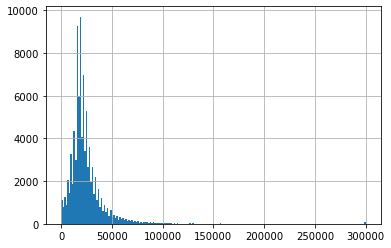

In [34]:
X['prior_question_elapsed_time'].hist(bins=200)

<AxesSubplot:>

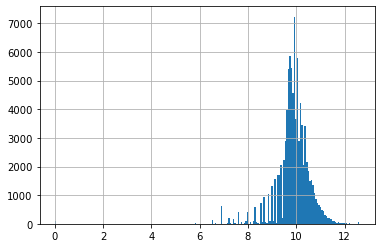

In [35]:
X['prior_question_elapsed_time'].map(lambda x:np.log(1+x)).hist(bins=200)

Text(0.5, 0, '')

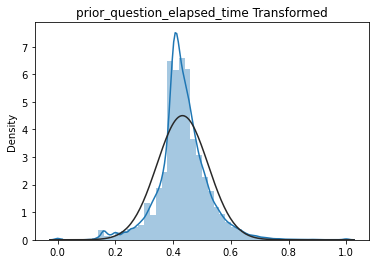

In [47]:
from scipy import stats 
columns = X.columns.tolist()

def scale_minmax(col):
    return (col-col.min())/(col.max()-col.min())
trans_var,lambda_var = stats.boxcox(X['prior_question_elapsed_time'].dropna()+1)
trans_var = scale_minmax(trans_var)
sns.distplot(trans_var,fit=stats.norm)
plt.title('prior_question_elapsed_time'+' Transformed')
plt.xlabel('')
# def regplot(X,columns):
#     fcols = 6
#     frows = len(columns)
#     plt.figure(figsize=(5*fcols,5*frows))

#     i=0
#     for col in columns:
#         i+=1
#         ax = plt.subplot(frows,fcols,i)
#         sns.regplot(x=col,y='answered_correctly',data=X,ax=ax,scatter_kws={'marker':'.','s':3,'alpha':0.3},line_kws={'color':'k'})
#         plt.xlabel(col)
#         plt.ylabel('target')

#         i+=1
#         ax =plt.subplot(frows,fcols,i)
#         sns.distplot(X[col].dropna())
#         plt.xlabel(col)

In [32]:
y = X['answered_correctly']
X = X.drop(['answered_correctly'], axis=1)
y_val = validation['answered_correctly']
X_val = validation.drop(['answered_correctly'], axis=1)

In [34]:
columns_features = [c for c in X.columns if c not in ['user_id','content_id','prior_question_had_explanation']]
X = X[columns_features]
X_val = X_val[columns_features]

X.fillna(-1,inplace=True)  # 这块有操作空间
validation.fillna(-1,inplace=True)

In [35]:
X

,row_id,task_container_id,prior_question_elapsed_time,user_y_mean,user_y_sum,user_y_count,user_y_std,content_y_mean,content_y_sum,content_y_count,content_y_std,user_t_mean,user_t_sum,user_t_count,user_t_std,content_t_mean,content_t_sum,content_t_count,content_t_std,prior_question_had_explanation_enc
0,537344,0,-1.0,-1.000000,-1.0,-1.0,-1.000000,0.625000,10.0,16.0,0.500000,-1.000000,-1.0,-1.0,-1.000000,18312.500000,293000.0,16.0,8949.627553,0
1,770120,0,-1.0,-1.000000,-1.0,-1.0,-1.000000,0.500000,21.0,42.0,0.506061,-1.000000,-1.0,-1.0,-1.000000,22857.142578,960000.0,42.0,15503.849134,0
2,416905,0,-1.0,-1.000000,-1.0,-1.0,-1.000000,0.663866,158.0,238.0,0.473381,-1.000000,-1.0,-1.0,-1.000000,24335.427734,5791832.0,238.0,17921.699265,0
3,965472,0,-1.0,-1.000000,-1.0,-1.0,-1.000000,0.601064,113.0,188.0,0.490987,-1.000000,-1.0,-1.0,-1.000000,25359.042969,4767500.0,188.0,21675.353142,0
4,873183,0,-1.0,-1.000000,-1.0,-1.0,-1.000000,1.000000,15.0,15.0,0.000000,-1.000000,-1.0,-1.0,-1.000000,23357.142578,327000.0,14.0,11091.279616,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94631,662870,-86,32667.0,0.619700,1900.0,3066.0,0.485540,0.420000,21.0,50.0,0.498569,24506.777344,75113272.0,3065.0,16920.048528,53858.621094,2692931.0,50.0,32463.106961,1
94632,206761,45,20666.0,0.587629,1083.0,1843.0,0.492395,0.921053,35.0,38.0,0.273276,27363.031250,50402704.0,1842.0,34365.765502,21705.052734,824792.0,38.0,8503.521636,1
94633,856993,-31,36200.0,0.479363,662.0,1381.0,0.499755,0.581218,229.0,394.0,0.493987,36977.703125,51029232.0,1380.0,32618.053736,26945.925781,10589749.0,393.0,27342.571456,0
94634,312074,37,24000.0,0.598211,1672.0,2795.0,0.490347,0.689189,51.0,74.0,0.465985,25374.408203,70896096.0,2794.0,26630.084037,23405.406250,1732000.0,74.0,16594.566217,1


In [38]:
import lightgbm as lgb

params = {
            'boosting_type': 'gbdt',
            'objective': 'regression_l2',
            'metric': 'mse',
            'min_child_weight': 1.5,
            'num_leaves': 2**5,
            'lambda_l2': 10,
            'subsample': 0.7,
            'colsample_bytree': 0.7,
            'colsample_bylevel': 0.7,
            'learning_rate': 0.03,
            'tree_method': 'exact',
            'seed': 2017,
            'nthread': 12,
            'silent': True,
        }

lgb_train = lgb.Dataset(X,y)
lgb_eval = lgb.Dataset(X_val,y_val,reference=lgb_train)

In [39]:
model=lgb.train(
        params,
        lgb_train,
        valid_sets=[lgb_train,lgb_eval],
        num_boost_round=10000,
        early_stopping_rounds=10
)

[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006223 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4716
[LightGBM] [Info] Number of data points in the train set: 94636, number of used features: 20
[LightGBM] [Warning] Unknown parameter: tree_method
[LightGBM] [Warning] Unknown parameter: colsample_bylevel
[LightGBM] [Warning] Unknown parameter: silent
[LightGBM] [Info] Start training from score 0.563496
[1]	training's l2: 0.243656	valid_1's l2: 0.246756
Training until validation scores don't improve for 10 rounds
[2]	training's l2: 0.241477	valid_1's l2: 0.245107
[3]	training's l2: 0.

In [41]:
df_features_import = pd.DataFrame()
df_features_import['columns_features'] = columns_features

gbm_features = pd.DataFrame({'feature_importance':model.feature_importance(),'columns_features':columns_features}).sort_values(['feature_importance'],ascending=0)
gbm_features

,feature_importance,columns_features
0,1360,row_id
2,1189,prior_question_elapsed_time
7,1103,content_y_mean
3,985,user_y_mean
1,973,task_container_id
18,938,content_t_std
10,887,content_y_std
14,834,user_t_std
15,820,content_t_mean
11,817,user_t_mean


<Figure size 7200x7200 with 0 Axes>

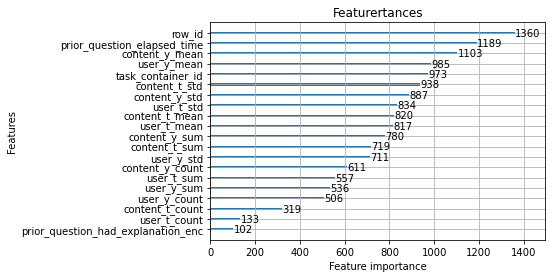

In [43]:
plt.figure(figsize=(100,100))
lgb.plot_importance(model, max_num_features=30)
plt.title("Featurertances")
plt.show()

In [48]:
y_pred = model.predict(X_val)
y_true = np.array(y_val)
roc_auc_score(y_true,y_pred)

0.7048478568832174

In [ ]:
iter_test = env.iter_test()

for (test_df, sample_prediction_df) in iter_test:
	test_df = pd.merge(test_df, results_u_final, on=['user_id'],  how="left")
	test_df = pd.merge(test_df, results_c_final, on=['content_id'],  how="left")
	test_df = pd.merge(test_df, results_ut_final, on=['user_id'],  how="left")
	test_df = pd.merge(test_df, results_ct_final, on=['content_id'],  how="left")

    test_df['prior_question_had_explanation'].fillna(False, inplace=True)
    test_df["prior_question_had_explanation_enc"] = lb_make.fit_transform(test_df["prior_question_had_explanation"])

    X_test = test_df[columns_features]
    X_test.fillna(-1, inplace=True)

    test_df['answered_correctly'] =  model.predict(X_test)
    env.predict(test_df.loc[test_df['content_type_id'] == 0, ['row_id', 'answered_correctly']])
